In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, filtfilt

import numpy as np

import re
import pickle

from dataset import MotionDataset
from time_model import TimeModel
from tqdm.notebook import tqdm

data_path = "/home/meribejayson/Desktop/Projects/realistic-imu/data/total_capture_data"
subjects = ["s5"]

minimized_dataset = MotionDataset(data_path, subjects=subjects, dataset_type="minimized", minimize=True)
minimized_loader = DataLoader(minimized_dataset, batch_size=1, shuffle=False)

orig_dataset = MotionDataset(data_path, subjects=subjects, dataset_type="orig", minimize=False)
orig_loader = DataLoader(orig_dataset, batch_size=1, shuffle=False)

## Mean Squared Error of only applying a finite difference

In [2]:
num_exps = 0
total = 0

for mocap, imu in tqdm(orig_loader):
    diff = imu[0, :, :] - mocap[0, :, 0:26:2]
    sqr = diff ** 2

    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

12.683247566223145

## Mean Squared Error with minimized accelerations

In [3]:
num_exps = 0
total = 0

for mocap, imu in tqdm(minimized_loader):
    diff = imu[0, :, :] - mocap[0, :, 0:26:2]
    sqr = diff ** 2

    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

11.728960990905762

## Mean Squared error with moving average

In [4]:
num_exps = 0
total = 0

for mocap, imu in tqdm(orig_loader):
    avg_mocap = uniform_filter1d(mocap[0, :, 0:26:2].numpy(), size=11, mode='nearest', axis=0)
    diff = imu[0, :, :] - avg_mocap
    sqr = diff ** 2
    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

13.127171516418457

## Mean Squared error with butterworth filter

In [5]:
def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)

cutoff = 10
fs = 60
order = 1

num_exps = 0
total = 0

for mocap, imu in tqdm(orig_loader):
    avg_mocap = butterworth_filter(mocap[0, :, 0:26:2].numpy(), cutoff, fs, order)
    diff = imu[0, :, :] - avg_mocap
    sqr = diff ** 2
    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

11.479291288241145

## Mean Squared Error of model output

In [6]:
model_path = '/home/meribejayson/Desktop/Projects/realistic-imu/models/model_3.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# Load the model using pickle
try:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading the model: {e}")

# Move the model to the GPU (if available)
model = model.to(device)
model.eval()
print(f"Model moved to: {device}")

Using device: cuda
Model loaded successfully!
Model moved to: cuda


In [9]:
imus = []
diffs = []
num_exps = 0

for mocap, imu in tqdm(minimized_loader):
    avg_mocap = model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device)).cpu().detach().numpy()
    diff = imu[0, :, :] - avg_mocap.T
    diffs.append(diff)
    imus.append(imu)

    sqr = diff ** 2
    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

9.284856775533477

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_and_spectrum(diff):
    # Filter data within the bounds
    filtered_data = diff

    # Compute mean, variance and nyquist frequency
    mean_value = torch.mean(filtered_data)
    variance_value = torch.var(filtered_data)
    nyquist_frequency = 0.5 * len(filtered_data)

    # Plot histogram density
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(filtered_data, bins=30, density=True, alpha=0.7, color='blue')
    plt.title(f'Histogram Density\nMean: {mean_value:.2f}, Variance: {variance_value:.2f}')
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Compute and plot power spectrum
    plt.subplot(1, 2, 2)
    freq = np.fft.rfftfreq(len(filtered_data))
    power_spectrum = np.abs(np.fft.rfft(filtered_data)) ** 2
    plt.plot(freq, np.log10(power_spectrum), color='red')
    plt.title(f'Power Spectrum\nNyquist Frequency: {nyquist_frequency:.2f}')
    plt.xlabel('Frequency')
    plt.ylabel('Power')

    plt.tight_layout()
    plt.show()

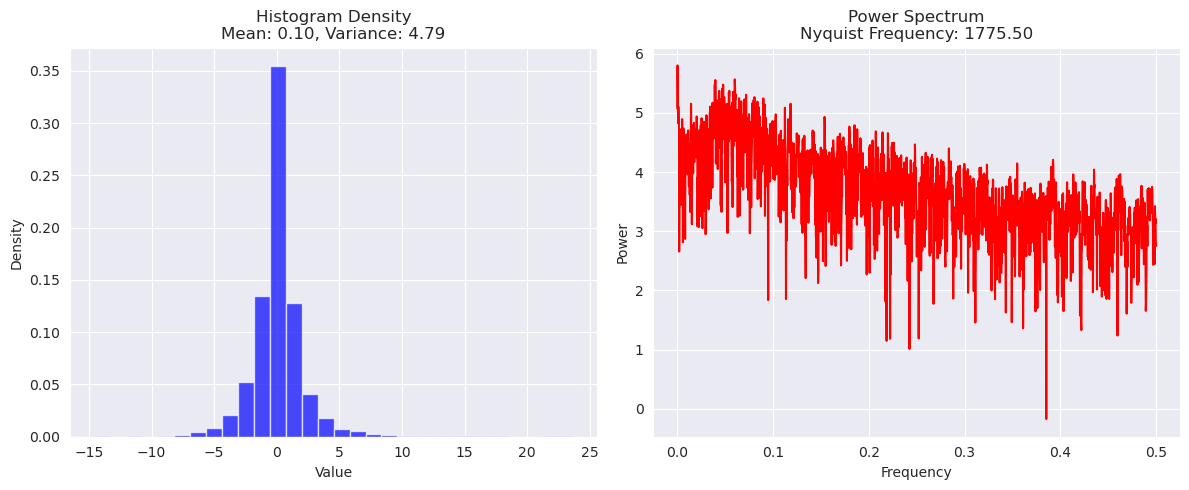

In [77]:
# Concatenate diffs and imu values from all trials and compute the plot
diffs_for_plot = diffs[2][:, 0]

plot_histogram_and_spectrum(diffs_for_plot)

In [78]:
from hurst import compute_Hc

# Calculate the Hurst exponent for diffs_for_plot
H, c, data = compute_Hc(diffs_for_plot.numpy(), kind='random_walk', simplified=True)

print(f"Hurst Exponent: {H:.4f}")
print(f"Scaling Coefficient: {c:.4f}")

Hurst Exponent: 0.2676
Scaling Coefficient: 2.3387


## Noise Bias Distribution over test dataset

In [8]:
noise_bias_values = []

NUM_OF_IMUS = 13
NUM_OF_NOISE_PARAMS = 9

def capture_noise_bias(module, input, output):
    noise_params = module.hidden_state_to_noise_params(module.norm1(input[0])).view(-1, NUM_OF_NOISE_PARAMS, NUM_OF_IMUS)  # Reconstruct noise_params
    noise_bias = noise_params[:, 8, :].T  # Extract noise_bias
    noise_bias_values.append(noise_bias.detach().cpu())

# Register the forward hook to `Noise_Regressor`
hook = model.noise_regressor.register_forward_hook(capture_noise_bias)

with torch.no_grad():
    for mocap, imu in tqdm(minimized_loader):
        avg_mocap = model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device))

hook.remove()

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
samples = torch.cat(noise_bias_values, dim=1).flatten().cpu().detach().numpy()

## What is the unconditioned distribution of the noise bias and what distribution does it look the most like
## Impossible to say without more analysis. With that said, the power spectral density is very pink, suggesting that 1/f noise or one of it higher orders might correctly describe the noise distribution
## Additionally the histogram appears to be very log normal

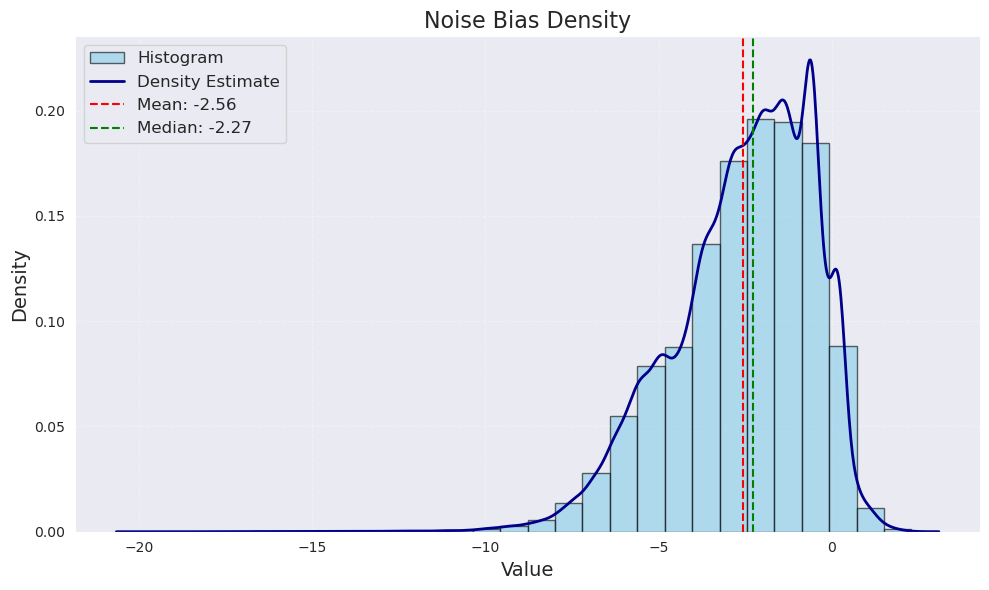

In [10]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(samples, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')

# Add KDE (Kernel Density Estimation) for smooth density estimation
kde = gaussian_kde(samples)
x_vals = np.linspace(min(samples), max(samples), 1000)
kde_vals = kde(x_vals)
plt.plot(x_vals, kde_vals, color='darkblue', lw=2, label='Density Estimate')

# Add annotations (mean and median)
mean = np.mean(samples)
median = np.median(samples)
plt.axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median:.2f}')

# Enhance plot aesthetics
plt.title('Noise Bias Density', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig('../figures/noise_bias_density.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

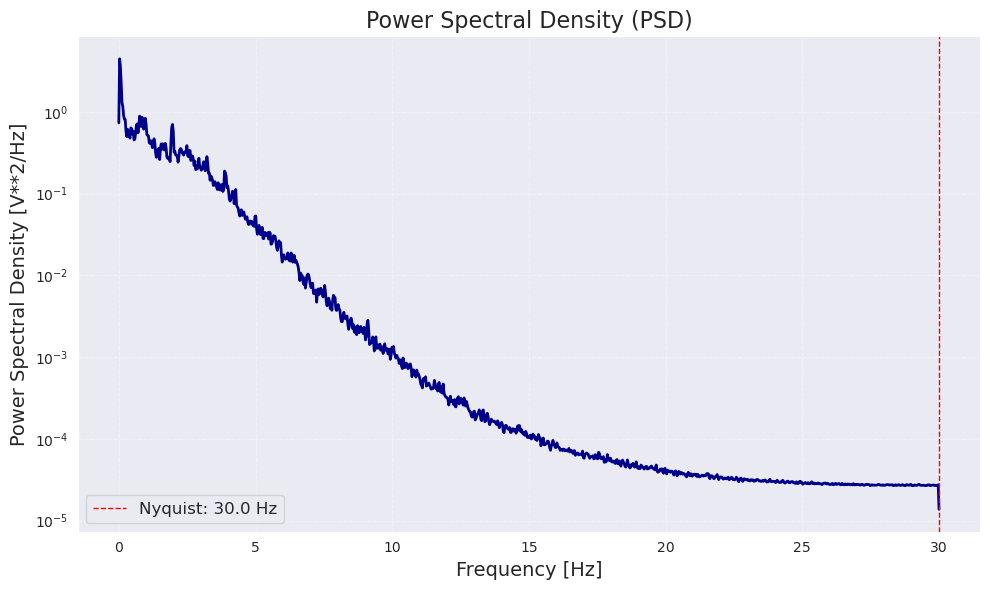

In [11]:
from scipy.signal import welch

# Compute Power Spectral Density (PSD) using Welch's method
fs = 60  # Sampling frequency in Hz
frequencies, psd = welch(samples, fs=fs, nperseg=2048)  # nperseg should be <= len(samples)

# Create the PSD plot
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd, color='darkblue', lw=2)

# Add labels, title, and grid for readability
plt.title('Power Spectral Density (PSD)', fontsize=16)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Power Spectral Density [V**2/Hz]', fontsize=14)
plt.grid(alpha=0.3, linestyle='--')

# Highlight the Nyquist frequency
nyquist = fs / 2
plt.axvline(nyquist, color='red', linestyle='--', linewidth=1, label=f'Nyquist: {nyquist} Hz')
plt.legend(fontsize=12)

plt.savefig('../figures/psd.png', dpi=600, bbox_inches='tight')

# Enhance plot aesthetics
plt.tight_layout()

## Does anything occur when we start conditioning on the magnitude of the input embedding to the noise regressor

## It appears that at smaller magnitudes the noise bias tends to vary more and seems to vary a lot as the magnitude of the embedding vector hits 50. After this point the variance decreases

In [12]:
noise_bias_values = []
input_magnitudes = []

NUM_OF_IMUS = 13
NUM_OF_NOISE_PARAMS = 9

def capture_noise_bias(module, input, output):
    noise_params = module.hidden_state_to_noise_params(module.norm1(input[0])).view(-1, NUM_OF_NOISE_PARAMS, NUM_OF_IMUS)  # Reconstruct noise_params
    noise_bias = noise_params[:, 8, :].T  # Extract noise_bias
    noise_bias_values.append(torch.sum(noise_bias, dim=0).detach().cpu())

# Register the forward hook to `Noise_Regressor`
hook = model.noise_regressor.register_forward_hook(capture_noise_bias)

with torch.no_grad():
    for mocap, imu in tqdm(minimized_loader):
        input_magnitudes.append(torch.norm(mocap, dim=2).squeeze(0).cpu())
        avg_mocap = model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device))


hook.remove()

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
noise_bias_values[0].shape

torch.Size([3728])

In [14]:
input_magnitudes[0].shape

torch.Size([3728])

In [15]:
noise = torch.cat(noise_bias_values, dim=0).flatten().cpu().detach().numpy()
input_magnitudes = torch.cat(input_magnitudes, dim=0).flatten().cpu().detach().numpy()

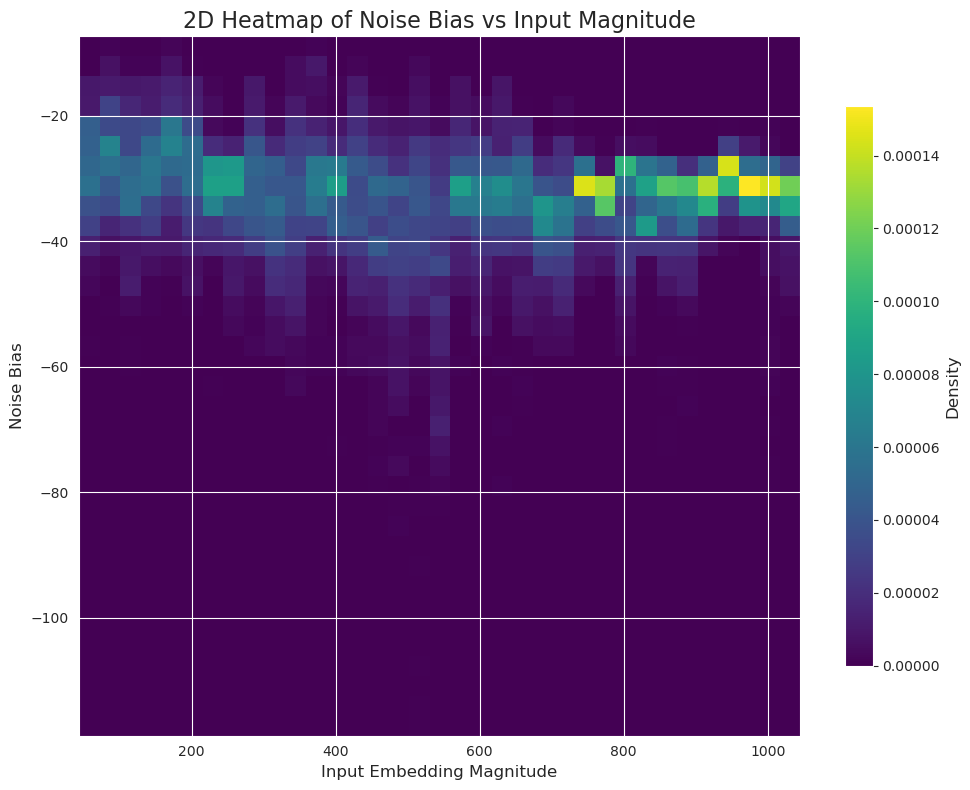

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

noise_bias_samples = noise
input_magnitudes = np.linspace(min(input_magnitudes), max(input_magnitudes), len(noise_bias_samples))

bins = 35
hist, x_edges, y_edges = np.histogram2d(input_magnitudes, noise_bias_samples, bins=bins, density=True)

x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = ax.imshow(hist.T, origin="lower", cmap="viridis",
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    aspect="auto")

cbar = fig.colorbar(heatmap, ax=ax, shrink=0.8)
cbar.set_label('Density', fontsize=12)

ax.set_title('2D Heatmap of Noise Bias vs Input Magnitude', fontsize=16)
ax.set_xlabel('Input Embedding Magnitude', fontsize=12)
ax.set_ylabel('Noise Bias', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/bias-magnitude-heatmap.png', dpi=600, bbox_inches='tight')

plt.show()

## Is there structure to the output embedding space


In [17]:
output_emb = []

NUM_OF_IMUS = 13
NUM_OF_NOISE_PARAMS = 9

def capture_noise_bias(module, input, output):
    output_emb.append(output.detach().cpu())

# Register the forward hook to `Noise_Regressor`
hook = model.encoder.register_forward_hook(capture_noise_bias)

with torch.no_grad():
    for mocap, imu in tqdm(minimized_loader):
        model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device))


hook.remove()

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
emb = torch.cat(output_emb, dim=1).cpu().squeeze(0).detach().numpy()
emb.shape

(19086, 512)

/home/meribejayson/anaconda3/envs/marker-to-ang/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


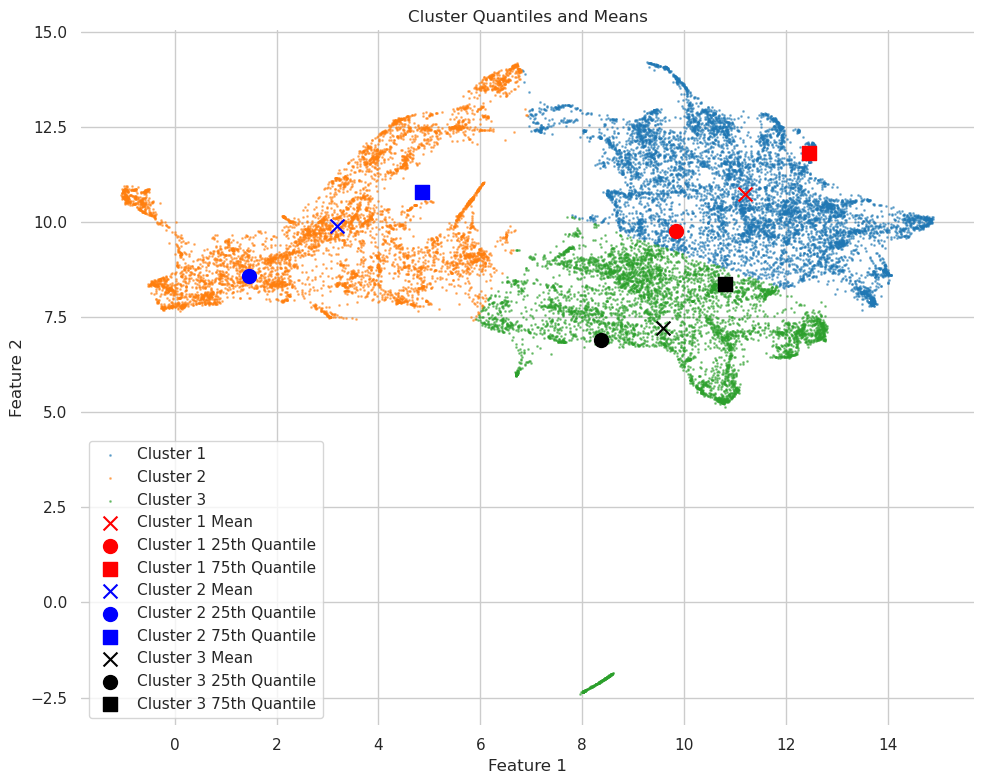

In [19]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.patches import Patch


# Normalize data
emb = StandardScaler().fit_transform(emb)

# UMAP with adjusted parameters
reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.01, random_state=42)
emb_2d = reducer.fit_transform(emb)

# Clustering to identify clusters for coloring
n_clusters = 3  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(emb_2d)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Define cluster colors
colors = sns.color_palette("tab10", n_clusters)

# Scatter plot with clusters
for cluster in range(n_clusters):
    plt.scatter(
        emb_2d[labels == cluster, 0], emb_2d[labels == cluster, 1],
        s=1, alpha=0.5, color=colors[cluster], label=f"Cluster {cluster+1}"
    )

# Add labels and title
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.title("UMAP Projection of Embedding Space with Clusters", fontsize=14, fontweight="bold")

# Remove spines for a cleaner look
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add larger legend with colored patches
legend_elements = [Patch(facecolor=colors[i], label=f"Cluster {i+1}") for i in range(n_clusters)]
plt.legend(handles=legend_elements, fontsize=15, loc="upper right", title="Clusters", title_fontsize=15)

cluster_1_mean = emb_2d[labels == 0].mean(axis=0)

cluster_1_25_quantile = np.quantile(emb_2d[labels == 0], 0.25, axis=0)
cluster_1_75_quantile = np.quantile(emb_2d[labels == 0], 0.75, axis=0)

cluster_2_mean = emb_2d[labels == 1].mean(axis=0)

cluster_2_25_quantile = np.quantile(emb_2d[labels == 1], 0.25, axis=0)
cluster_2_75_quantile = np.quantile(emb_2d[labels == 1], 0.75, axis=0)

cluster_3_mean = emb_2d[labels == 2].mean(axis=0)

cluster_3_25_quantile = np.quantile(emb_2d[labels == 2], 0.25, axis=0)
cluster_3_75_quantile = np.quantile(emb_2d[labels == 2], 0.75, axis=0)

plt.scatter(cluster_1_mean[0], cluster_1_mean[1], color='red', marker='x', s=100, label="Cluster 1 Mean")
plt.scatter(cluster_1_25_quantile[0], cluster_1_25_quantile[1], color='red', marker='o', s=100, label="Cluster 1 25th Quantile")
plt.scatter(cluster_1_75_quantile[0], cluster_1_75_quantile[1], color='red', marker='s', s=100, label="Cluster 1 75th Quantile")

# Adding cluster 2 points
plt.scatter(cluster_2_mean[0], cluster_2_mean[1], color='blue', marker='x', s=100, label="Cluster 2 Mean")
plt.scatter(cluster_2_25_quantile[0], cluster_2_25_quantile[1], color='blue', marker='o', s=100, label="Cluster 2 25th Quantile")
plt.scatter(cluster_2_75_quantile[0], cluster_2_75_quantile[1], color='blue', marker='s', s=100, label="Cluster 2 75th Quantile")

# Adding cluster 3 points
plt.scatter(cluster_3_mean[0], cluster_3_mean[1], color='black', marker='x', s=100, label="Cluster 3 Mean")
plt.scatter(cluster_3_25_quantile[0], cluster_3_25_quantile[1], color='black', marker='o', s=100, label="Cluster 3 25th Quantile")
plt.scatter(cluster_3_75_quantile[0], cluster_3_75_quantile[1], color='black', marker='s', s=100, label="Cluster 3 75th Quantile")

# Update legend
plt.legend()

# Add labels and title for clarity
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Cluster Quantiles and Means")

plt.tight_layout()
plt.savefig("../figures/embedding_umap_projection.png", dpi=900)

plt.show()

## What kind of outputs from the noise bias and the spring parameters usually output for say the imu on the foot for each cluster?

In [20]:
def find_nearest(target_point):
    closest_idx = 0
    for i in range(1, len(emb_2d)):
        dist = np.linalg.norm(emb_2d[i] - target_point)
        if dist < np.linalg.norm(emb_2d[closest_idx] - target_point):
            closest_idx = i
    return closest_idx

In [21]:
cluster_1_mean_point = emb[find_nearest(cluster_1_mean)]
cluster_1_25_quantile = emb[find_nearest(cluster_1_25_quantile)]
cluster_1_75_quantile = emb[find_nearest(cluster_1_75_quantile)]

cluster_2_mean_point = emb[find_nearest(cluster_2_mean)]
cluster_2_25_quantile = emb[find_nearest(cluster_2_25_quantile)]
cluster_2_75_quantile = emb[find_nearest(cluster_2_75_quantile)]

cluster_3_mean_point = emb[find_nearest(cluster_3_mean)]
cluster_3_25_quantile = emb[find_nearest(cluster_3_25_quantile)]
cluster_3_75_quantile = emb[find_nearest(cluster_3_75_quantile)]

In [22]:
import torch.nn.functional as F

class Noise_Series_Gen(nn.Module):
    def __init__(self, d_model, device):
        super(Noise_Series_Gen, self).__init__()

        self.norm1 = model.noise_regressor.norm1 # nn.LayerNorm(d_model)
        self.hidden_state_to_noise_params = model.noise_regressor.hidden_state_to_noise_params # nn.Linear(d_model, NUM_OF_IMUS * NUM_OF_NOISE_PARAMS)
        self.eps = 1e-5
        self.device = device

    """
        hidden_states should be of dimension (Batch, Sequence Len, Dim)
        B should always be 1
    """
    # PLEASE CONVERT TO EINOPS (this will be hardly readable to anyone but the people who live in my head)
    def forward(self, hidden_states):
        seq_len = hidden_states.shape[1]

        t_step = torch.triu(torch.arange(seq_len, device=self.device, dtype=torch.float32) - torch.arange(seq_len, device=self.device, dtype=torch.float32)[:, None])

        hidden_normed = self.norm1(hidden_states)
        noise_params = self.hidden_state_to_noise_params(hidden_normed).view(seq_len, NUM_OF_NOISE_PARAMS, NUM_OF_IMUS)

        c = noise_params[:, 4, :].view(seq_len, 1, NUM_OF_IMUS)
        c_theta = noise_params[:, 5, :].view(seq_len, 1, NUM_OF_IMUS)
        phi = noise_params[:, 6, :].view(seq_len, 1, NUM_OF_IMUS)
        phi_theta = noise_params[:, 7, :].view(seq_len, 1, NUM_OF_IMUS)

        d = ((noise_params[:, 1, :] ** 2).add(self.eps)).sqrt_().view(seq_len, 1, NUM_OF_IMUS)
        k = (d**2).div(4) + F.softplus(noise_params[:, 0, :]).view(seq_len, 1, NUM_OF_IMUS)

        d_theta = ((noise_params[:, 3, :] ** 2).add_(self.eps)).sqrt_().view(seq_len, 1, NUM_OF_IMUS)
        k_theta = (d_theta**2).div_(4) + F.softplus(noise_params[:, 2, :]).view(seq_len, 1, NUM_OF_IMUS)

        noise_bias = noise_params[:, 8, :].T

        dynamics_list = []
        for imu_num in range(NUM_OF_IMUS):
            k_imu = k[:, :, imu_num]
            d_imu = d[:, :, imu_num]
            omega1 = (k_imu.mul_(4) - (d_imu ** 2)).sqrt_() / 2

            exp_term_linear = ((-d_imu / 2) * t_step).exp_()
            sin_term_linear = (t_step * omega1).add_(phi[:, :, imu_num]).sin_()
            linear_dynamics = c[:, :, imu_num] * exp_term_linear * sin_term_linear

            k_theta_imu = k_theta[:, :, imu_num]
            d_theta_imu = d_theta[:, :, imu_num]
            omega1_theta = (k_theta_imu.mul_(4) - (d_theta_imu ** 2)).sqrt_() / 2

            exp_term_angular = ((-d_theta_imu / 2) * t_step).exp_()
            sin_term_angular = (t_step * omega1_theta).add_(phi_theta[:, :, imu_num]).sin_()
            angular_dynamics = c_theta[:, :, imu_num] * exp_term_angular * sin_term_angular

            spring_damper_dynamics_per_step = linear_dynamics.add_(angular_dynamics).triu_()

            dynamics_list.append(spring_damper_dynamics_per_step[0, :].reshape(1, -1))


        return torch.cat(dynamics_list, dim=0).add_(noise_bias)



In [23]:
def get_series_from_emb(emb):
    noise_series_gen = Noise_Series_Gen(d_model=512, device=device)

    inp = torch.zeros((1, 120, 512)).to(device)
    inp[0, 1, :] = torch.from_numpy(emb).to(device)

    with torch.no_grad():
        series = noise_series_gen(inp)

    return series.squeeze(0).cpu().numpy()


In [24]:
get_series_from_emb(cluster_1_mean_point)

array([[ -0.34001896,  -5.5424023 ,  -0.32489556, ...,  -0.58724463,
         -0.59187293,  -0.44095302],
       [ -0.443748  , -10.326326  ,  -1.2732679 , ...,  -0.44939548,
         -0.44163144,  -0.41766003],
       [ -0.2956292 , -11.789061  ,  -0.6808754 , ...,  -0.2747516 ,
         -0.26228032,  -0.27134946],
       ...,
       [ -0.03683011,  -3.6824474 ,  -0.03484872, ...,  -0.0423296 ,
         -0.04517217,  -0.04673177],
       [ -0.10661559,  -1.3161383 ,  -0.04711651, ...,  -0.10410315,
         -0.10560925,  -0.10691311],
       [ -0.06489877,   1.7189096 ,  -0.04601945, ...,  -0.06018732,
         -0.06678075,  -0.07143909]], dtype=float32)

In [25]:
import matplotlib.pyplot as plt

def plot_time_series(series, title="Time Series Plot", xlabel="Time", ylabel="Value", figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.plot(series, label="Time Series", color="blue", linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.legend(fontsize=12)
    plt.show()

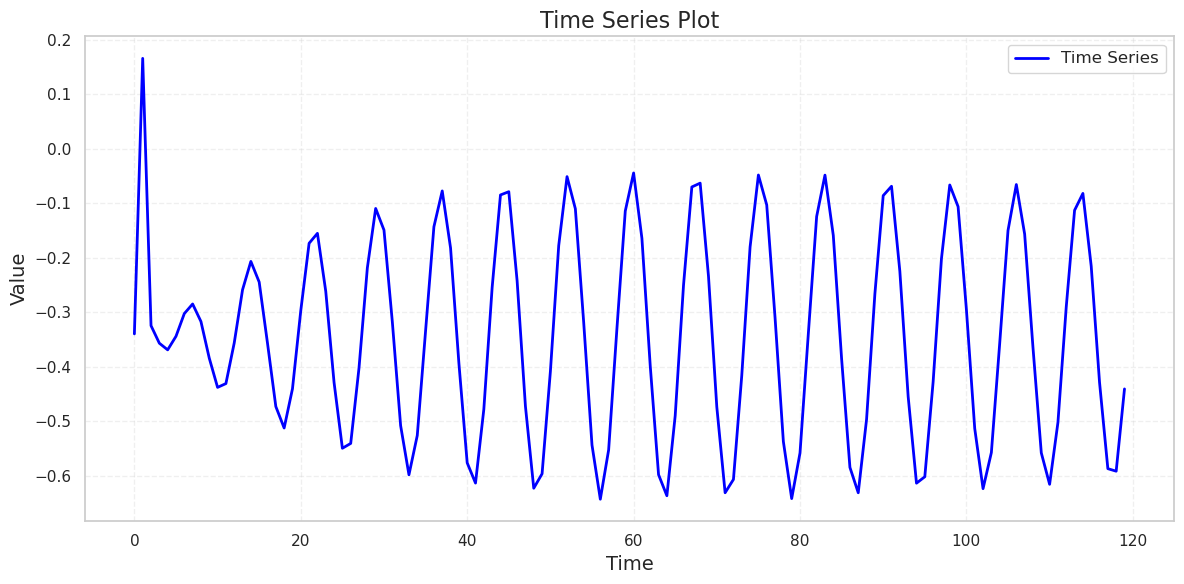

In [26]:
plot_time_series(get_series_from_emb(cluster_3_mean_point)[0])

In [27]:
import matplotlib.pyplot as plt

name = "head"

def plot_cluster_time_series(
    cluster_points,
    quantiles,
    labels,
    figsize=(14, 14)
):
    """
    Plot all cluster points as stacked time series in a visually appealing way,
    including quantiles (25th and 75th) for each cluster,
    allowing variable scales for each plot.

    Parameters:
    cluster_points (list of arrays): List of time series arrays corresponding to cluster points.
    quantiles (list of tuples): List of tuples where each tuple contains 25th and 75th quantile series arrays.
    labels (list of str): Labels for each cluster.
    title (str): Title of the plot.
    figsize (tuple): Size of the figure.
    """
    num_clusters = len(cluster_points)
    fig, axes = plt.subplots(num_clusters * 3, 1, figsize=figsize, sharex=True, constrained_layout=True)

    for i, (series, (q25, q75), label) in enumerate(zip(cluster_points, quantiles, labels)):
        # Plot mean time series
        axes[i * 3].plot(series, color='blue', lw=1.5, label=f"{label} Mean")
        axes[i * 3].set_title(f"{label} Mean", fontsize=14)
        axes[i * 3].grid(alpha=0.3, linestyle="--")
        axes[i * 3].set_ylabel("Value", fontsize=12)
        axes[i * 3].legend(fontsize=10)

        # Plot 25th quantile
        axes[i * 3 + 1].plot(q25, color='orange', lw=1.5, label=f"{label} 25th Quantile")
        axes[i * 3 + 1].set_title(f"{label} 25th Quantile", fontsize=14)
        axes[i * 3 + 1].grid(alpha=0.3, linestyle="--")
        axes[i * 3 + 1].set_ylabel("Value", fontsize=12)
        axes[i * 3 + 1].legend(fontsize=10)

        # Plot 75th quantile
        axes[i * 3 + 2].plot(q75, color='green', lw=1.5, label=f"{label} 75th Quantile")
        axes[i * 3 + 2].set_title(f"{label} 75th Quantile", fontsize=14)
        axes[i * 3 + 2].grid(alpha=0.3, linestyle="--")
        axes[i * 3 + 2].set_ylabel("Value", fontsize=12)
        axes[i * 3 + 2].legend(fontsize=10)

    axes[-1].set_xlabel("Time", fontsize=12)

    plt.savefig(f'../figures/added-kinematics-{name}.png', dpi=600, bbox_inches='tight')

    plt.show()

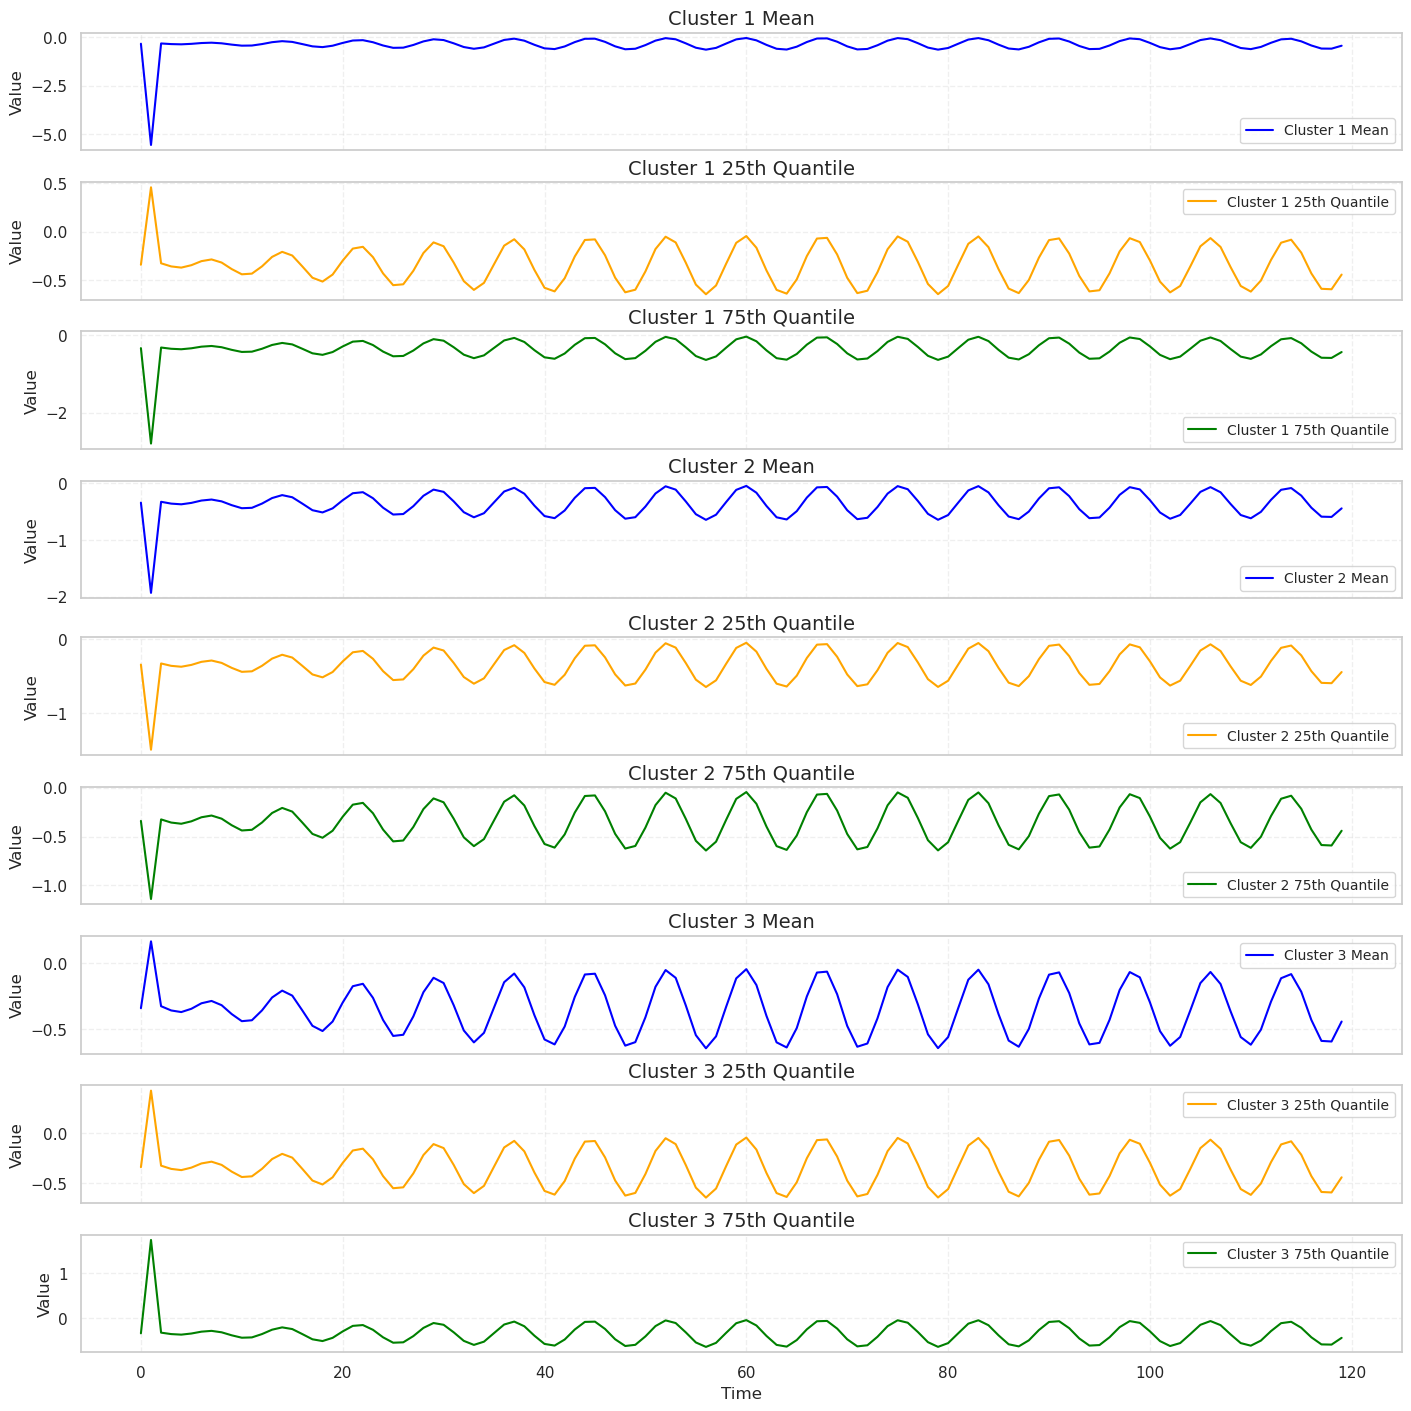

In [28]:
imu_idx = 0

# Example usage with quantiles:
cluster_points = [
    get_series_from_emb(cluster_1_mean_point)[imu_idx],
    get_series_from_emb(cluster_2_mean_point)[imu_idx],
    get_series_from_emb(cluster_3_mean_point)[imu_idx]
]
quantiles = [
    (get_series_from_emb(cluster_1_25_quantile)[imu_idx], get_series_from_emb(cluster_1_75_quantile)[imu_idx]),
    (get_series_from_emb(cluster_2_25_quantile)[imu_idx], get_series_from_emb(cluster_2_75_quantile)[imu_idx]),
    (get_series_from_emb(cluster_3_25_quantile)[imu_idx], get_series_from_emb(cluster_3_75_quantile)[imu_idx])
]

# Plot with updated functionality
plot_cluster_time_series(cluster_points, quantiles,["Cluster 1", "Cluster 2", "Cluster 3"])

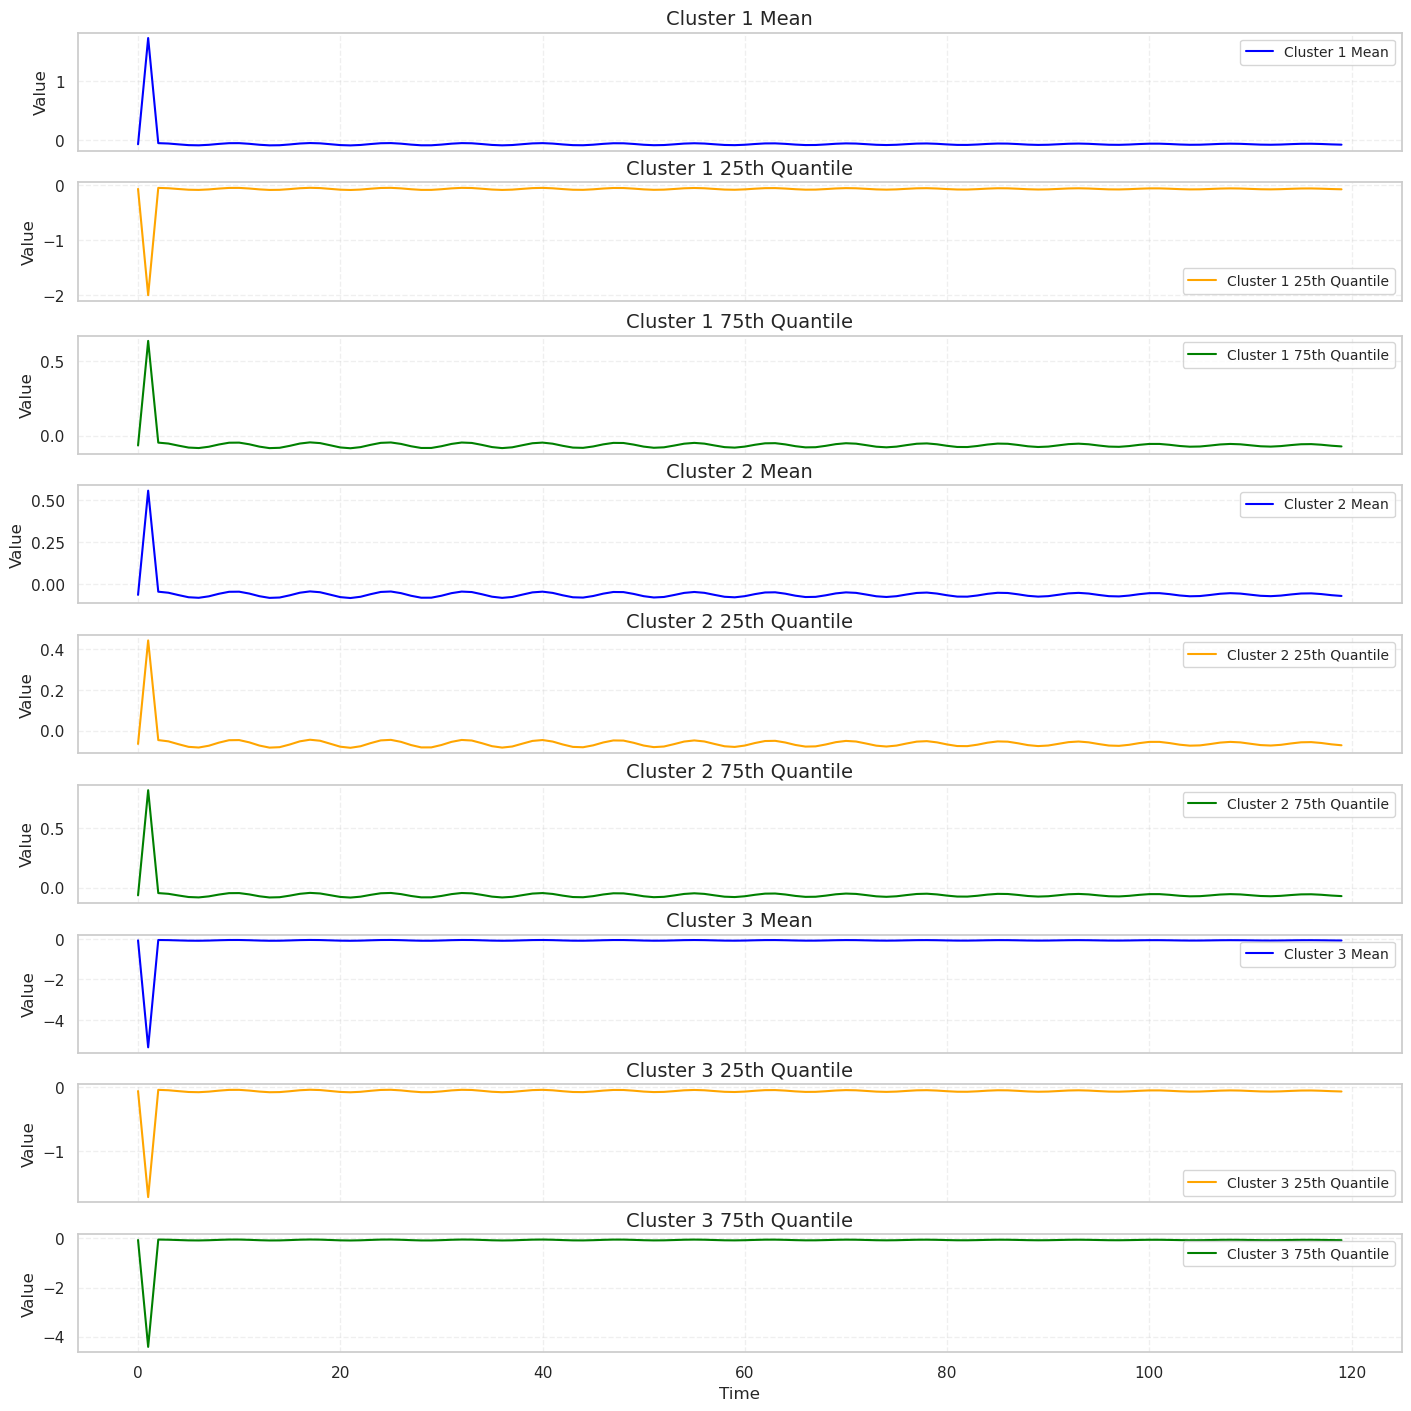

In [29]:
imu_idx = -1

name = "left foot"
# Example usage with quantiles:
cluster_points = [
    get_series_from_emb(cluster_1_mean_point)[imu_idx],
    get_series_from_emb(cluster_2_mean_point)[imu_idx],
    get_series_from_emb(cluster_3_mean_point)[imu_idx]
]
quantiles = [
    (get_series_from_emb(cluster_1_25_quantile)[imu_idx], get_series_from_emb(cluster_1_75_quantile)[imu_idx]),
    (get_series_from_emb(cluster_2_25_quantile)[imu_idx], get_series_from_emb(cluster_2_75_quantile)[imu_idx]),
    (get_series_from_emb(cluster_3_25_quantile)[imu_idx], get_series_from_emb(cluster_3_75_quantile)[imu_idx])
]

# Plot with updated functionality
plot_cluster_time_series(cluster_points, quantiles,["Cluster 1", "Cluster 2", "Cluster 3"])

## Observations:

### Based on the limb the direction of the noise bias tend to stay together.
### Some limbs, like the right foot essentially have no use of the spring kinematics, while others like the head do?
### It appears that most of the time the oscillatory behavior is not decaying, rather it seem as though the model chooses arbitrary oscillatory behavior to fit itself to the imu data
### It appears the model generally make more use of the noise bias than the spring dynamics
### Given that the model is trying its absolute hardest to approximate some aribtitrary fourier series we might as well just allow it to do so and take the speed increase

## More Questions
### What is the mean and variance of the noise bias in each cluster
### Find notable examples where the spring dynamics are used and are not.
### What parts of the sequence matter most for these predictions? Is it simply just what is nearest? Or could different clusters require have verying attention maps. If it is clear that the model isn't using local information it means we could probably drop the transformer
### I wonder how well this would do on synthesized data from nimble



## What is the mean and variance of the noise bias in each cluster

In [30]:
class Kinematic_Paramters(nn.Module):
    def __init__(self, d_model, device):
        super(Kinematic_Paramters, self).__init__()

        self.norm1 = model.noise_regressor.norm1 # nn.LayerNorm(d_model)
        self.hidden_state_to_noise_params = model.noise_regressor.hidden_state_to_noise_params # nn.Linear(d_model, NUM_OF_IMUS * NUM_OF_NOISE_PARAMS)
        self.eps = 1e-5
        self.device = device

    """
        hidden_states should be of dimension (Batch, Sequence Len, Dim)
        B should always be 1
    """
    def forward(self, hidden_states):
        seq_len = hidden_states.shape[1]

        hidden_normed = self.norm1(hidden_states)
        noise_params = self.hidden_state_to_noise_params(hidden_normed).view(seq_len, NUM_OF_NOISE_PARAMS, NUM_OF_IMUS)

        c = noise_params[:, 4, :].view(seq_len, 1, NUM_OF_IMUS)
        c_theta = noise_params[:, 5, :].view(seq_len, 1, NUM_OF_IMUS)
        phi = noise_params[:, 6, :].view(seq_len, 1, NUM_OF_IMUS)
        phi_theta = noise_params[:, 7, :].view(seq_len, 1, NUM_OF_IMUS)

        d = ((noise_params[:, 1, :] ** 2).add(self.eps)).sqrt_().view(seq_len, 1, NUM_OF_IMUS)
        k = (d**2).div(4) + F.softplus(noise_params[:, 0, :]).view(seq_len, 1, NUM_OF_IMUS)

        d_theta = ((noise_params[:, 3, :] ** 2).add_(self.eps)).sqrt_().view(seq_len, 1, NUM_OF_IMUS)
        k_theta = (d_theta**2).div_(4) + F.softplus(noise_params[:, 2, :]).view(seq_len, 1, NUM_OF_IMUS)

        noise_bias = noise_params[:, 8, :].T

        return (c, phi, d, k), (c_theta, phi_theta, d_theta, k_theta), noise_bias

In [31]:
emb_copy = torch.from_numpy(emb[np.newaxis, :, :]).to(device)

kp = Kinematic_Paramters(d_model=512, device=device)

linear, angular, noise_bias = kp(emb_copy)
c, phi, d, k = linear
c_theta, phi_theta, d_theta, k_theta = angular
labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [32]:
def plot_histograms(cluster_idx, target_imu):
    filter = labels == cluster_idx
    param_names = ['c', 'phi', 'd', 'k', 'c_theta', 'phi_theta', 'd_theta', 'k_theta', 'noise_bias']
    param_values = [c[filter, 0, target_imu], phi[filter, 0, target_imu], d[filter, 0, target_imu], k[filter, 0, target_imu],
                    c_theta[filter, 0, target_imu], phi_theta[filter, 0, target_imu], d_theta[filter, 0, target_imu], k_theta[filter, 0, target_imu],
                    noise_bias[target_imu, filter]]

    plt.figure(figsize=(18, 12))

    for i, (name, values) in enumerate(zip(param_names, param_values), 1):
        values_np = values.detach().cpu().numpy().flatten()
        mean_val = values_np.mean()
        var_val = values_np.var()

        plt.subplot(3, 3, i)
        plt.hist(values_np, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)  # Added `density=True`
        plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        plt.axvline(mean_val + var_val**0.5, color='green', linestyle='--', label=f'+1 Std Dev')
        plt.axvline(mean_val - var_val**0.5, color='green', linestyle='--', label=f'-1 Std Dev')
        plt.title(f'Histogram of {name} for cluster {cluster_idx + 1}', fontsize=14)
        plt.xlabel(f'{name}', fontsize=12)
        plt.ylabel('Density', fontsize=12)  # Changed from 'Frequency' to 'Density'
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3, linestyle='--')

    plt.tight_layout()

    plt.savefig(f'../figures/param_dist-{cluster_idx}.png', dpi=600, bbox_inches='tight')
    plt.show()

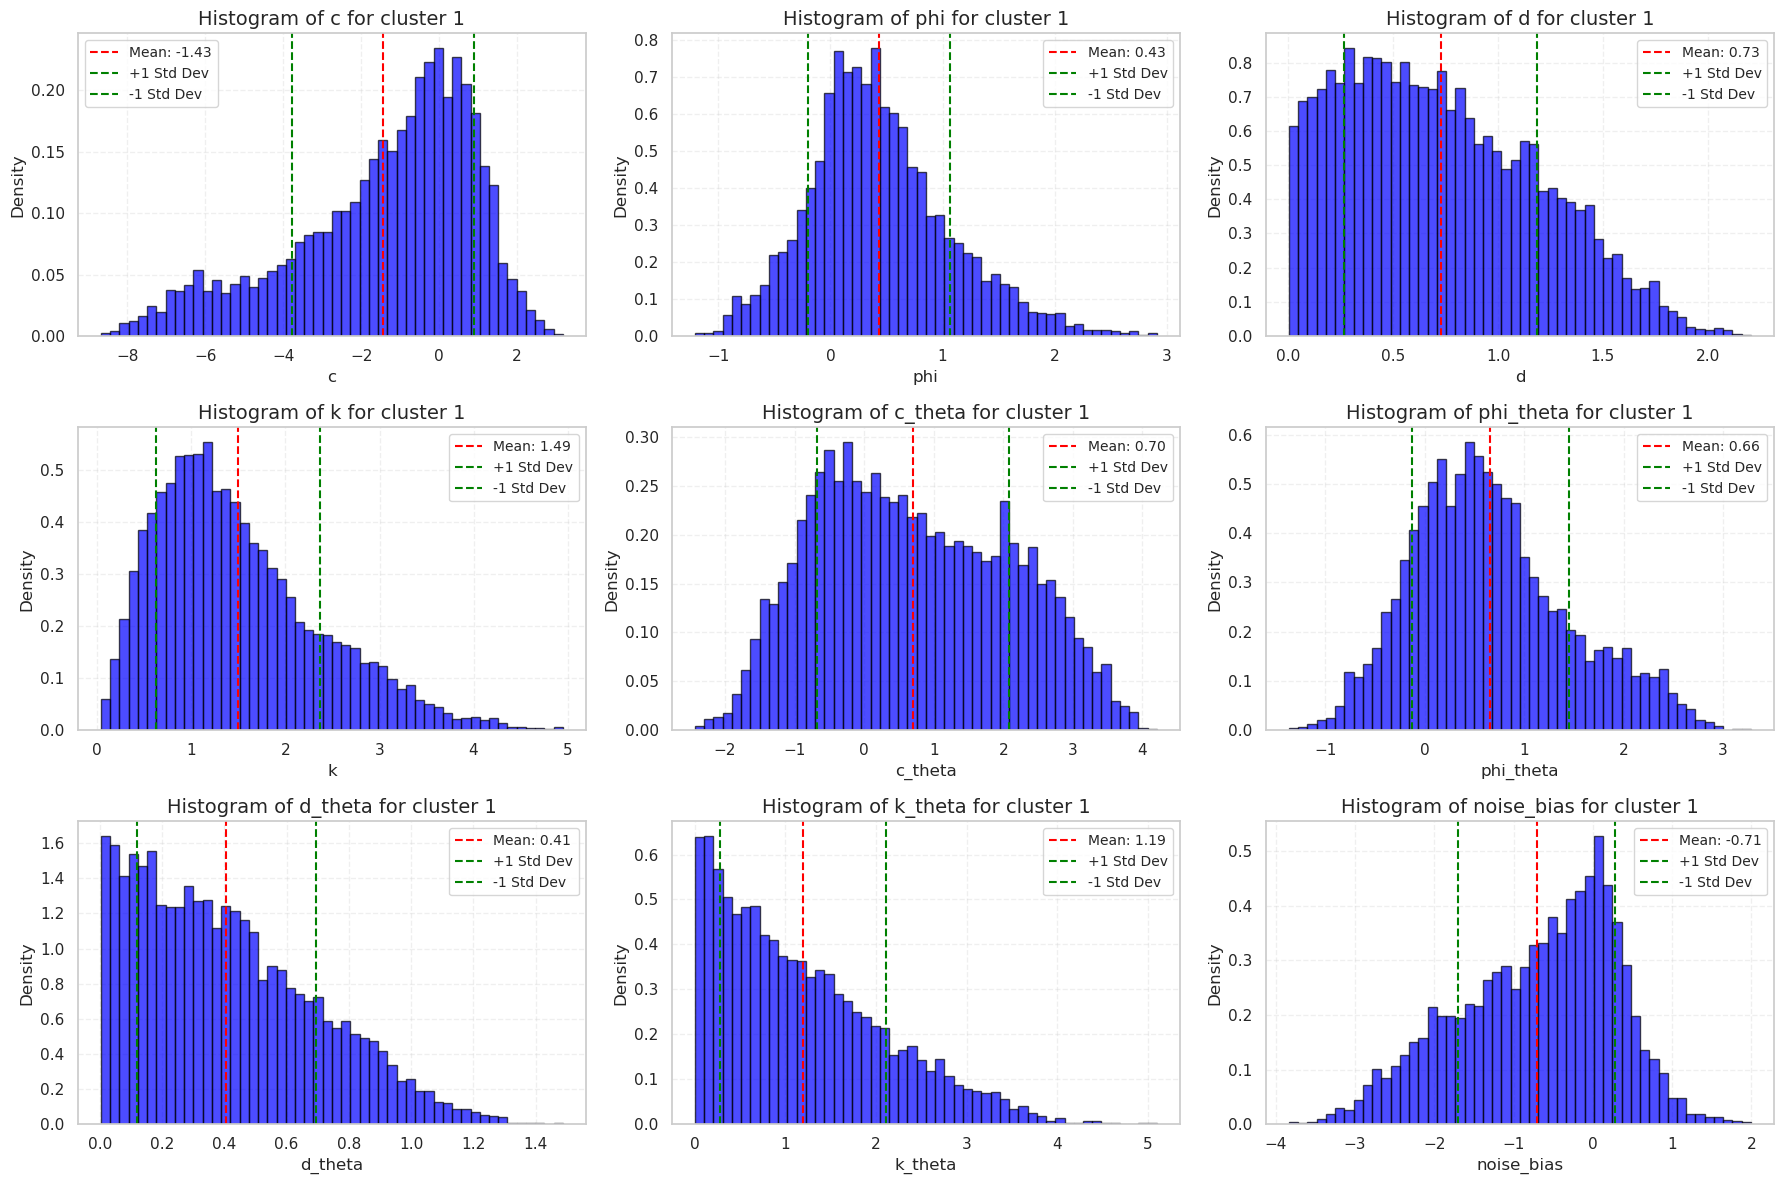

In [33]:
plot_histograms(0, -4)

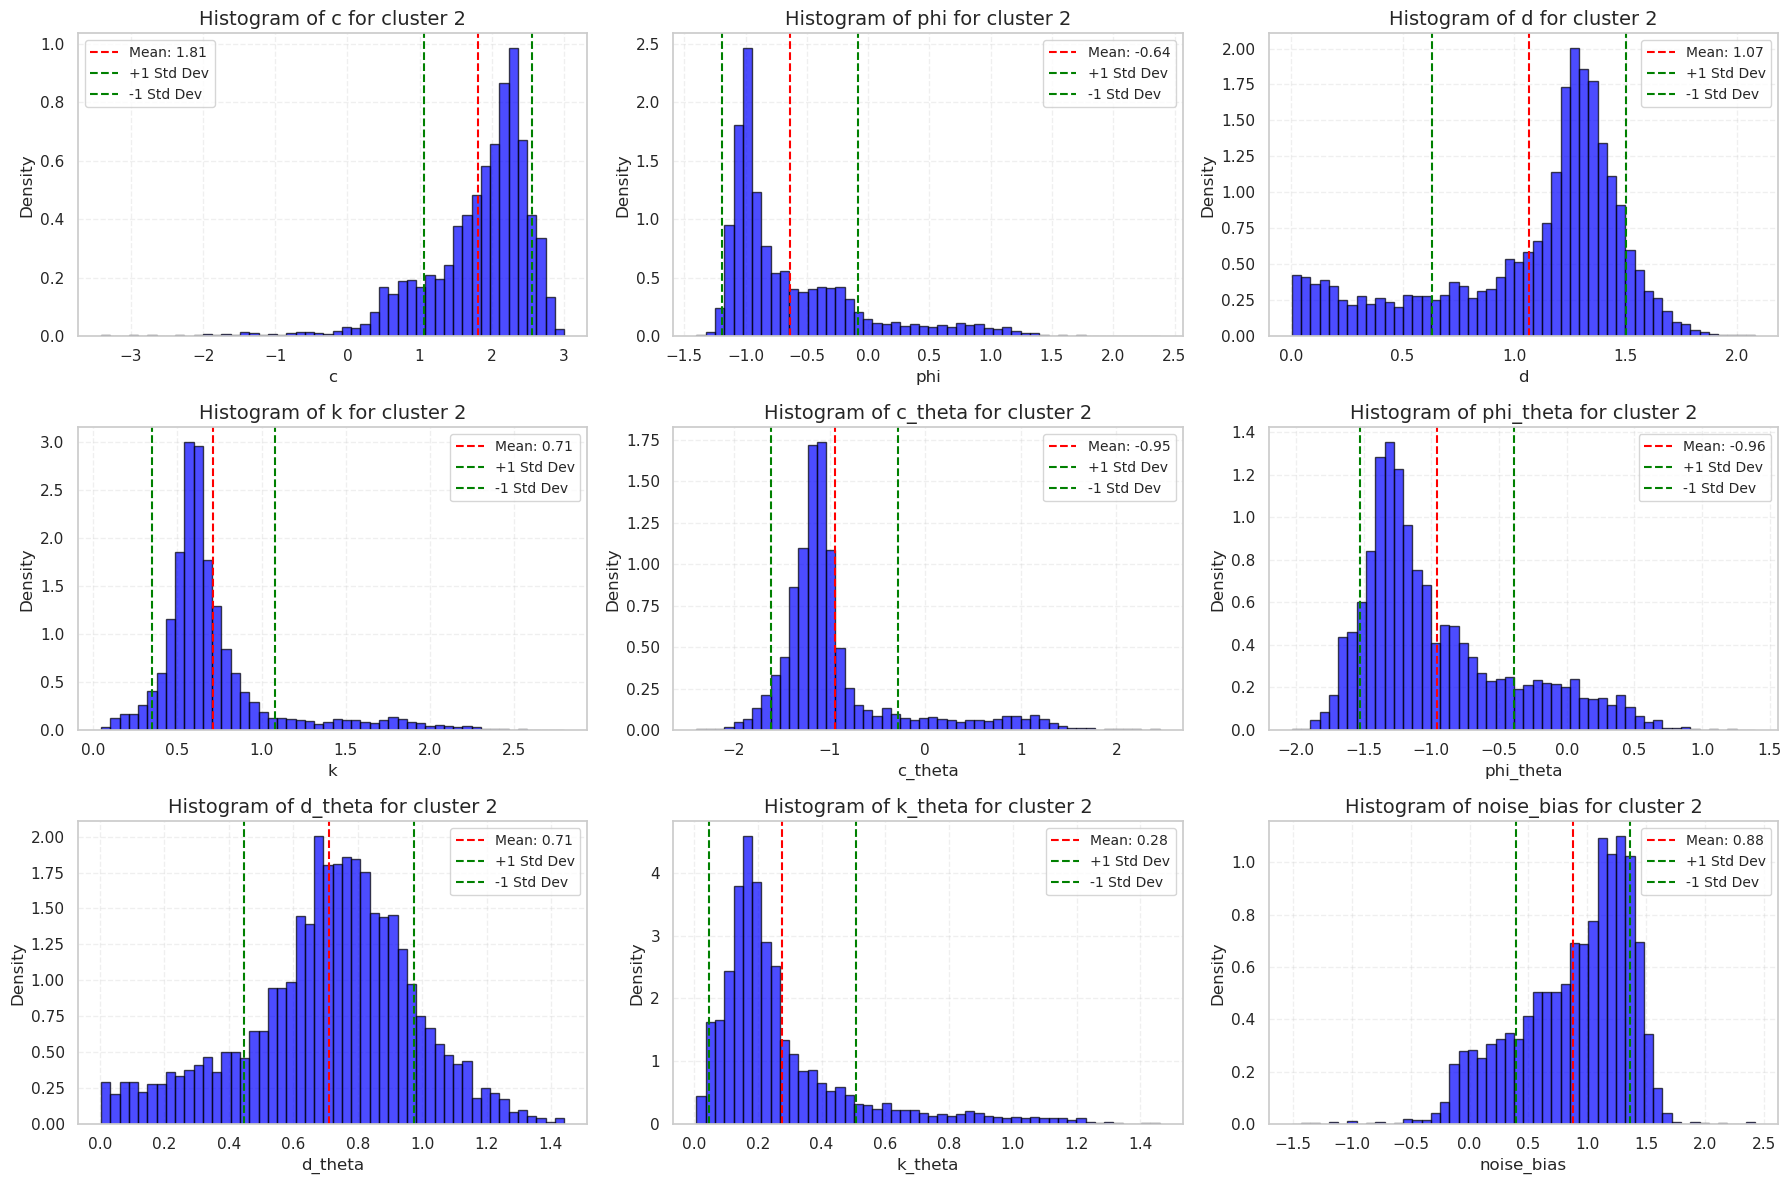

In [34]:
plot_histograms(1, -4)

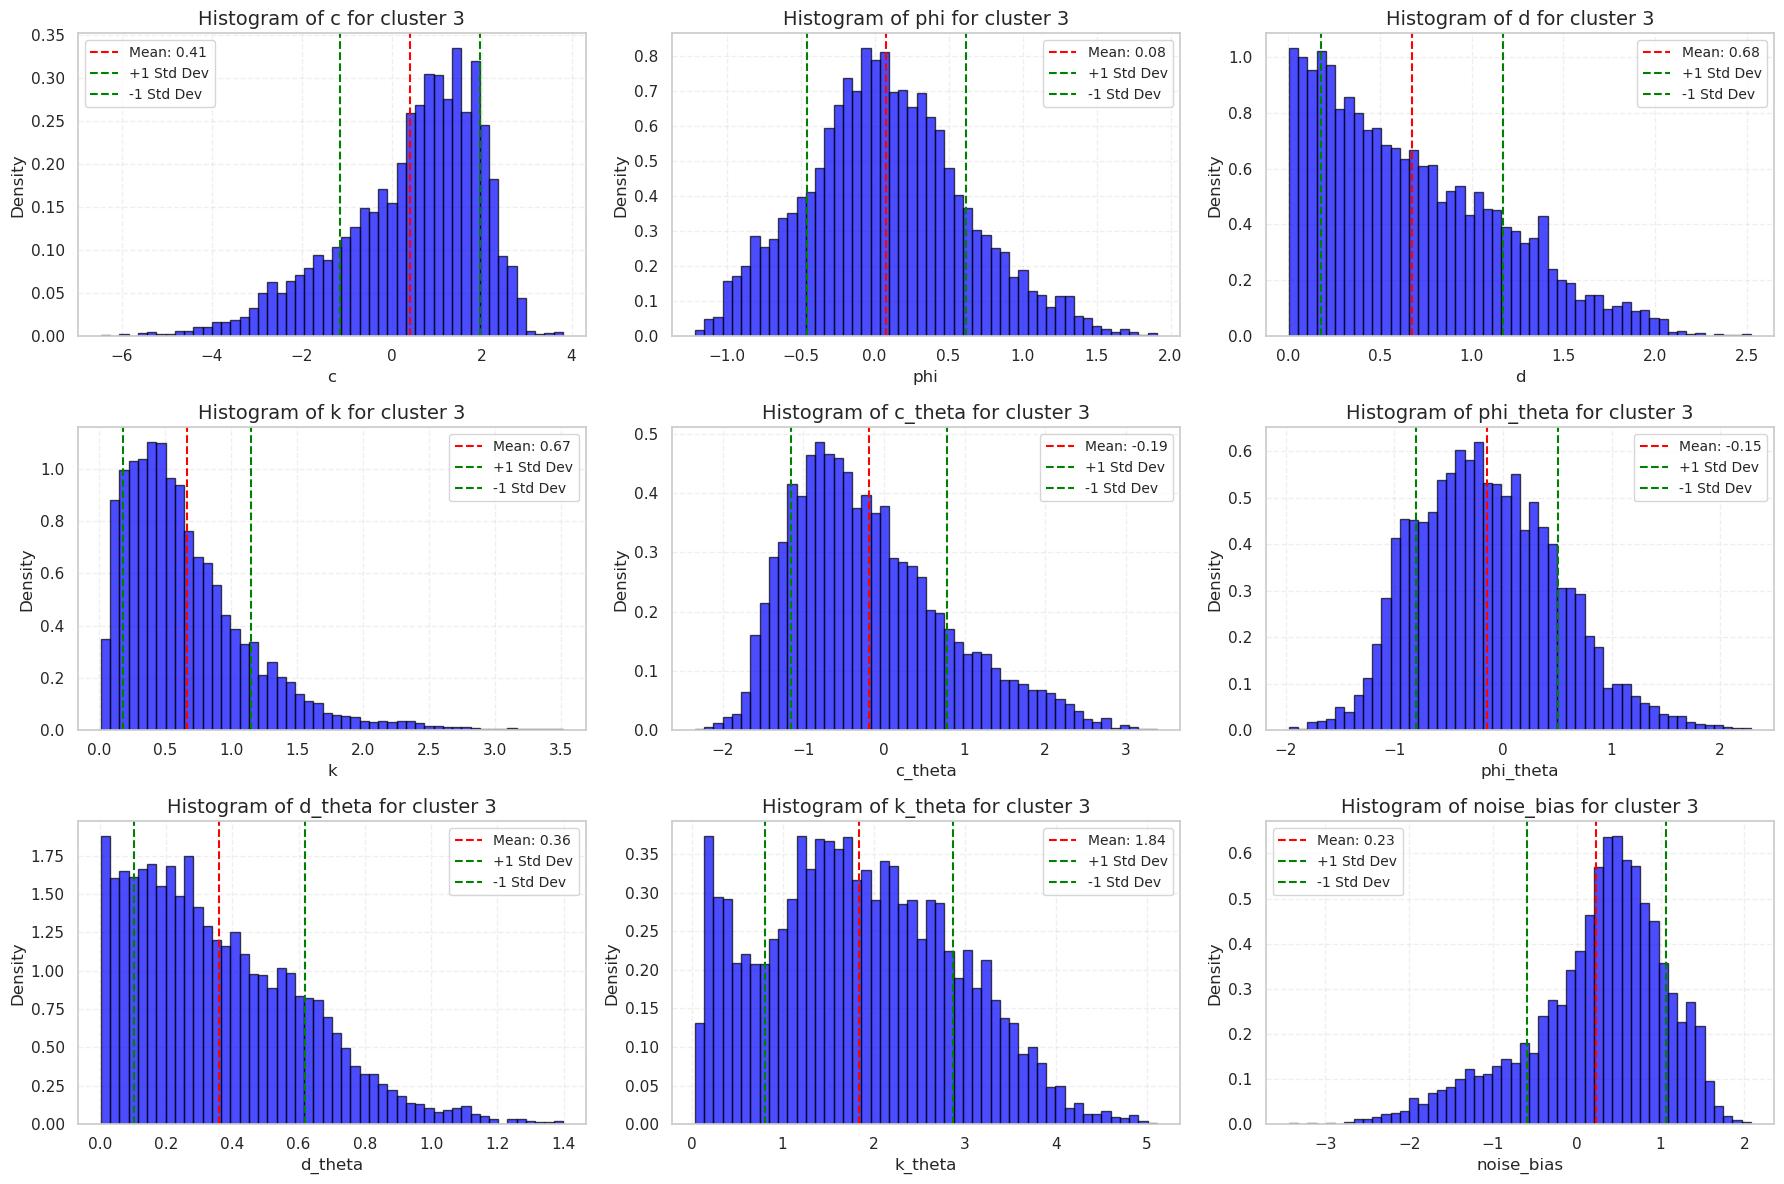

In [35]:
plot_histograms(2, -4)

## Observations:

### Spring kinematics seem vary wildy based on what cluster the come from. Some from are obviously skewed while others have almost symmetric PDFs

## What matters most for predictions

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom TransformerEncoderLayer that always returns attention weights
class MyTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        # Override to always request attention weights
        x, attn_weights = self.self_attn(
            x, x, x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            is_causal=is_causal
        )
        return self.dropout1(x), attn_weights

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        if self.norm_first:
            sa_out, attn_weights = self._sa_block(self.norm1(x), src_mask, src_key_padding_mask, is_causal=is_causal)
            x = x + sa_out
            x = x + self._ff_block(self.norm2(x))
        else:
            sa_out, attn_weights = self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal)
            x = self.norm1(x + sa_out)
            x = self.norm2(x + self._ff_block(x))
        return x

# Assuming your model is already loaded and stored in 'model'
# For example: model = torch.load('my_loaded_model.pt') or similar.

# Extract the original layers from the model
original_layers = model._orig_mod.encoder.transformer_encoder.layers

# Create a new ModuleList for the modified layers
new_layers = nn.ModuleList()

for old_layer in original_layers:
    # Use GELU since original was using gelu, if needed
    # If you know the original activation was gelu, this is safe
    # Otherwise, detect from old_layer.activation_relu_or_gelu if possible
    act_fn = F.gelu

    new_layer = MyTransformerEncoderLayer(
        d_model=old_layer.self_attn.embed_dim,
        nhead=old_layer.self_attn.num_heads,
        dim_feedforward=old_layer.linear1.weight.shape[0],
        dropout=old_layer.dropout.p,
        activation=act_fn,
        layer_norm_eps=old_layer.norm1.eps,
        batch_first=old_layer.self_attn.batch_first,
        norm_first=old_layer.norm_first,
        bias=True if old_layer.linear1.bias is not None else False
    )

    # Copy state_dict from old_layer to new_layer
    new_layer.load_state_dict(old_layer.state_dict())
    new_layers.append(new_layer)

# Replace the old layers with the new ones in the model
model._orig_mod.encoder.transformer_encoder.layers = new_layers

class HookedEncoder(nn.Module):
    def __init__(self, model):
        super(HookedEncoder, self).__init__()

        self.attention_weights = []

        # Reference the updated encoder components from model._orig_mod
        self.encoder_layer = model._orig_mod.encoder.encoder_layer
        self.transformer_encoder = model._orig_mod.encoder.transformer_encoder
        self.norm1 = model._orig_mod.encoder.norm1
        self.norm2 = model._orig_mod.encoder.norm2
        self.feed_forward = model._orig_mod.encoder.feed_forward

        def hook_fn(module, input, output):
            # output is (attn_output, attn_weights)
            # module is the MultiheadAttention
            # We registered the hook on self_attn which returns (attn_output, attn_weights)
            attn_weights = output[1]
            self.attention_weights.append(attn_weights)

        # Register hooks to capture attention weights
        for layer in self.transformer_encoder.layers:
            layer.self_attn.register_forward_hook(hook_fn)

    def forward(self, x):
        residual = x
        x_norm = self.norm1(x)
        x_trans = self.transformer_encoder(x_norm)
        x_norm_2 = self.norm2(x_trans)
        ff_out = self.feed_forward(x_norm_2)
        return ff_out + residual

class Truncated_Model(nn.Module):
    def __init__(self, model):
        super(Truncated_Model, self).__init__()

        # Reference initial layers from model._orig_mod
        self.linear1 = model._orig_mod.linear1
        self.layer_norm1 = model._orig_mod.layer_norm1
        self.activation1 = model._orig_mod.activation1
        self.encoder = HookedEncoder(model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.layer_norm1(x)
        x = self.activation1(x)
        encoded_states = self.encoder(x)
        return encoded_states, self.encoder.attention_weights

# Use your device, for example:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trunc_model = Truncated_Model(model).to(device)


In [37]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns


trunc_model.eval()
with torch.no_grad():
    encoded_states, attn = trunc_model(torch.from_numpy(minimized_dataset.__getitem__(0)[0]).to(device))

def visualize_attention_weights():
    num_layers = len(attn)
    fig, axes = plt.subplots(3, 4, figsize=(20, 15), dpi=300)

    for idx, ax in enumerate(axes.flat):
        if idx < num_layers:
            layer_attn = attn[idx].detach().cpu().numpy()[480:600, 480:600]
            sns.heatmap(layer_attn, annot=False, cmap='magma', cbar=False, square=True, ax=ax)
            ax.set_title(f'Layer {idx + 1}', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.savefig(f'../figures/attention-map.png', dpi=600, bbox_inches='tight')
    plt.show()

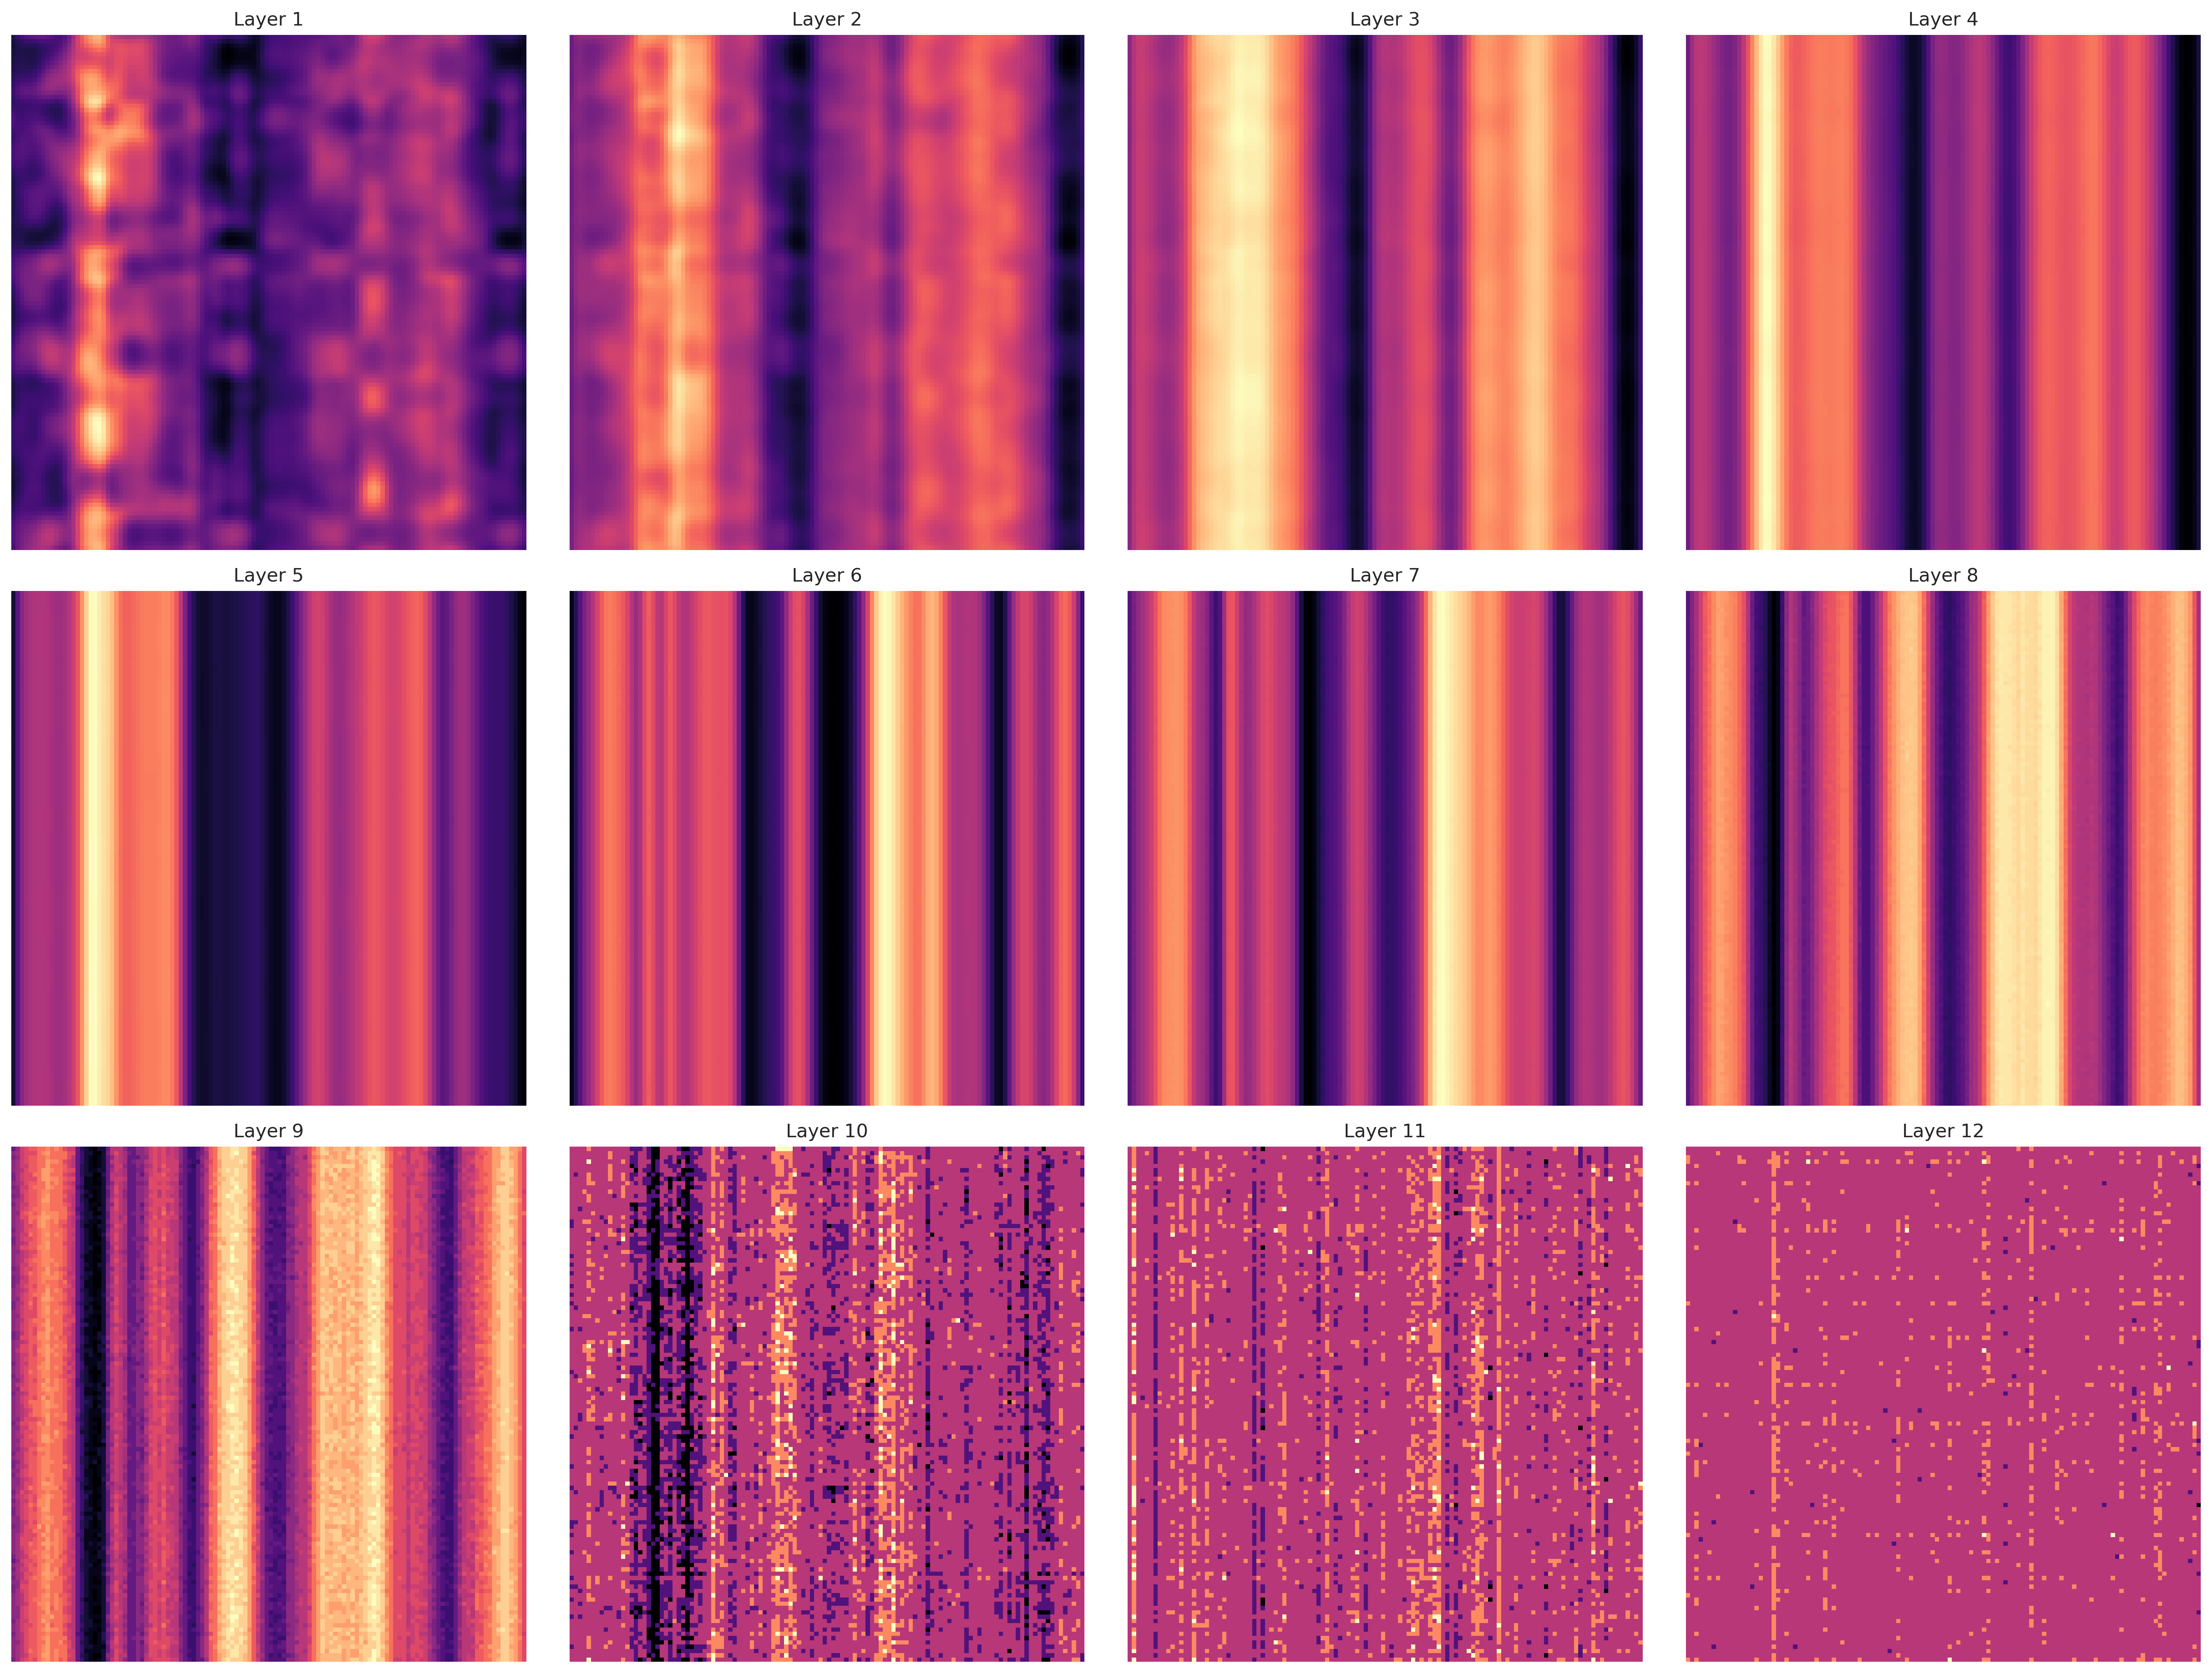

In [38]:
visualize_attention_weights()

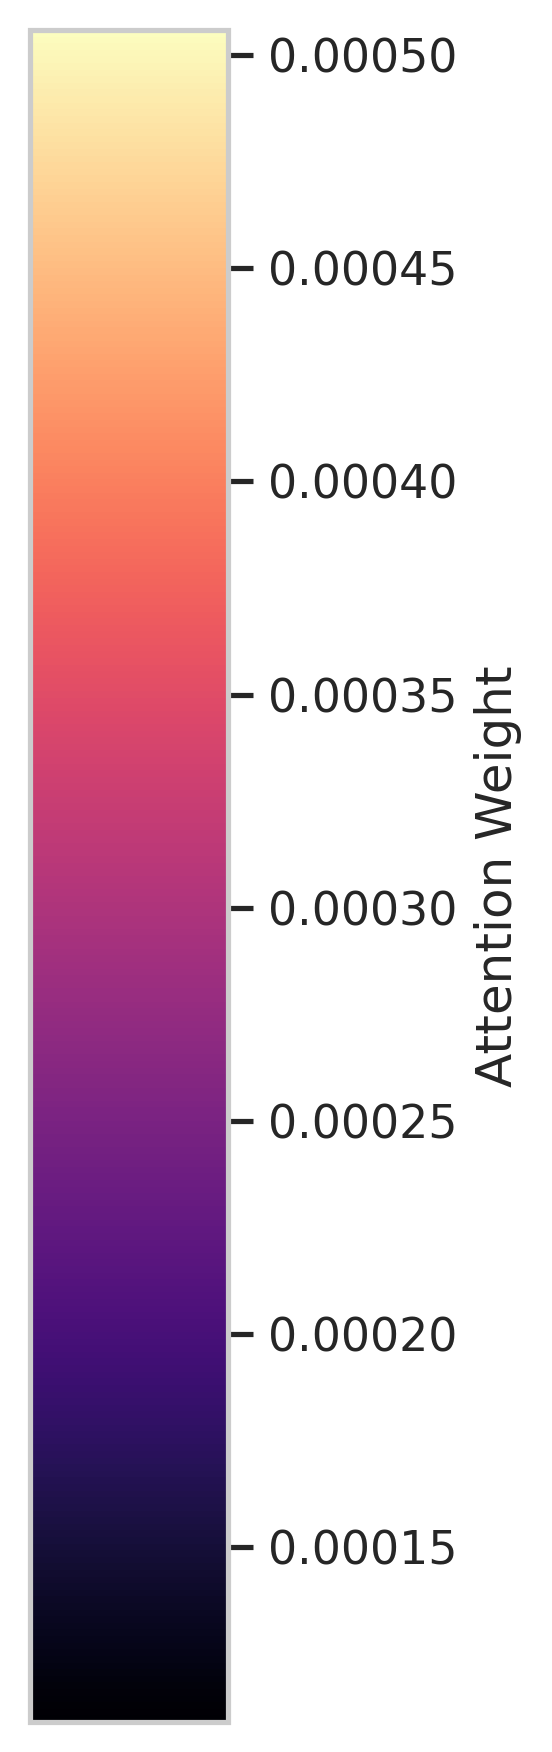

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def create_colorbar_from_data(data, cmap='magma', label='Attention Weight'):
    min_val = min(layer.min() for layer in data)
    max_val = max(layer.max() for layer in data)

    fig, ax = plt.subplots(figsize=(2, 6), dpi=300)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_val, vmax=max_val))
    cbar = fig.colorbar(sm, cax=ax)
    cbar.set_label(label, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'../figures/color-bar-key.png', dpi=600, bbox_inches='tight')
    plt.show()


create_colorbar_from_data(attn, cmap='magma', label='Attention Weight')


## Observations:

## The attention maps are oddly not what you would expect. You would expect the attention maps to first be extremely local and gradually branch out.
## However, what we observe is that in the earlier layers timesteps tend to attending to the same things. The attention weight only become more diverse in the later layers and not even really

In [40]:
minimized_dataset.trial_order[2]

('s5', 'freestyle3')

In [41]:
import matplotlib.pyplot as plt

def stack_four_time_series(time, series1, series2, series3, series4,
                           xlabel=None, title1=None, title2=None, title3=None, title4=None):
    # Use a valid Matplotlib style (e.g., 'default' or 'classic')
    plt.style.use('default')  # 'default' ensures broad compatibility across Matplotlib versions.
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 10), gridspec_kw={'hspace': 0.4})

    # Determine the overall y-axis limits for consistency across all plots
    ymin = min(series1.min(), series2.min(), series3.min(), series4.min())
    ymax = max(series1.max(), series2.max(), series3.max(), series4.max())

    # Plot the series with consistent y-axis limits
    axes[0].plot(time, series1, color='blue', linewidth=1.5)
    axes[0].set_title(title1)
    axes[0].grid(True)
    axes[0].set_ylim(ymin, ymax)

    axes[1].plot(time, series2, color='green', linewidth=1.5)
    axes[1].set_title(title2)
    axes[1].grid(True)
    axes[1].set_ylim(ymin, ymax)

    axes[2].plot(time, series3, color='red', linewidth=1.5)
    axes[2].set_title(title3)
    axes[2].grid(True)
    axes[2].set_ylim(ymin, ymax)

    axes[3].plot(time, series4, color='purple', linewidth=1.5)
    axes[3].set_title(title4)
    axes[3].set_xlabel(xlabel)
    axes[3].grid(True)
    axes[3].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig(f'../figures/time-series-graphs.png', dpi=600, bbox_inches='tight')
    plt.show()

model = None
try:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading the model: {e}")

model.eval()

series_mocap = minimized_dataset.__getitem__(2)[0]
series_imu = minimized_dataset.__getitem__(2)[1]

print(series_imu.shape)

input_mocap = torch.from_numpy(series_mocap).to(device).unsqueeze(0)

with torch.no_grad():
    pred_imu = model(input_mocap, input_mocap[0, :, 0:26:2].T).detach().cpu().numpy()

filtered = butterworth_filter(input_mocap[0, :, 0:26:2].detach().cpu().numpy(), cutoff, fs, order)

time  = np.arange(series_mocap.shape[0])

Model loaded successfully!
(3551, 13)


In [42]:
pred_imu.shape

(13, 3551)

/tmp/ipykernel_4917/1438849221.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


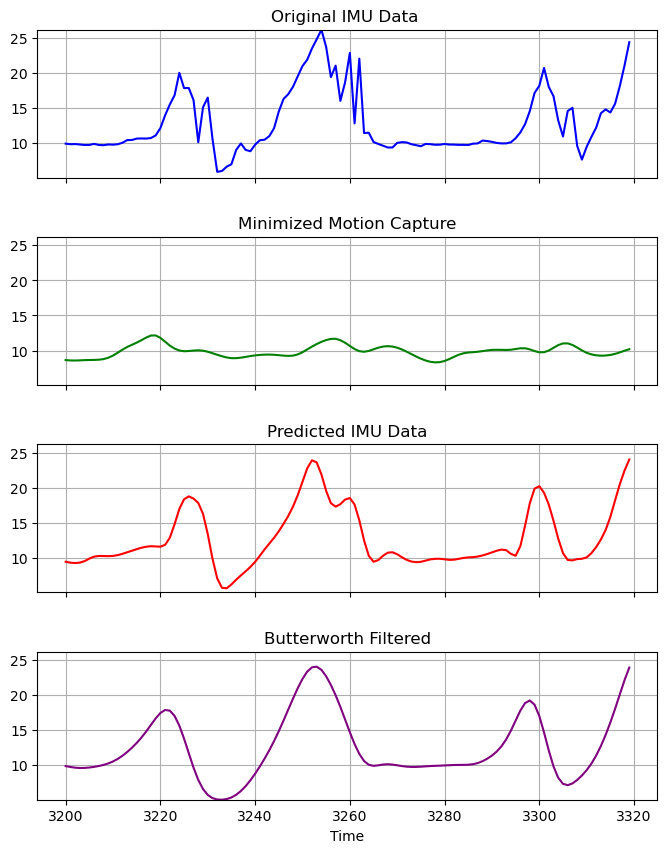

Mean Squared Error (IMU vs Mocap): 27.33768081665039
Mean Squared Error (IMU vs Predicted): 3.294523000717163
Mean Squared Error (IMU vs Filtered): 10.117767087072501


In [43]:
# Define the upper and lower bounds
lower_bound = 3200
upper_bound = lower_bound + 120
imu_limb = -2

# Create mask based on the bounds
mask = (time >= lower_bound) & (time < upper_bound)

# Select the specific column into separate variables
imu_selected_data = series_imu[mask, imu_limb]
mocap_selected_data = series_mocap[mask, imu_limb]
pred_imu_selected_data = pred_imu.T[mask, imu_limb]
filtered_selected_data = filtered[mask, imu_limb]

# Pass the selected data to the plotting function
stack_four_time_series(
    time[mask], imu_selected_data, mocap_selected_data, pred_imu_selected_data, filtered_selected_data,
    xlabel='Time',
    title1='Original IMU Data ',
    title2='Minimized Motion Capture',
    title3='Predicted IMU Data',
    title4='Butterworth Filtered'
)

# Calculate Mean Squared Errors
mse_imu_vs_mocap = ((imu_selected_data - mocap_selected_data) ** 2).mean()
mse_imu_vs_pred = ((imu_selected_data - pred_imu_selected_data) ** 2).mean()
mse_imu_vs_filtered = ((imu_selected_data - filtered_selected_data) ** 2).mean()

# Print the calculated MSEs
print(f"Mean Squared Error (IMU vs Mocap): {mse_imu_vs_mocap}")
print(f"Mean Squared Error (IMU vs Predicted): {mse_imu_vs_pred}")
print(f"Mean Squared Error (IMU vs Filtered): {mse_imu_vs_filtered}")

## Stuff still left to do:
### Compare your synthesized imu data to nimble's
